Version: v19.04

Candidate ID:

Question 1: Load

Programmatically download and load into your favorite analytical tool the transactions data. This data, which is in line-delimited JSON format, can be found at https://github.com/CapitalOneRecruiting/DS
Please describe the structure of the data. Number of records and fields in each record?
Please provide some additional basic summary statistics for each field. Be sure to include a count of null, minimum, maximum, and unique values where appropriate.

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, classification_report
#from xgboost.sklearn import XGBClassifier
#import lightgbm as lgb
#from keras.models import Sequential
#from keras.layers import Dense, Dropout



import datetime
#from time import time
import time
import warnings
warnings.filterwarnings('ignore')

# to display the total number columns present in the dataset
pd.set_option('display.max_columns', None)

In [2]:
df=pd.read_json('transactions.txt', lines=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641914 entries, 0 to 641913
Data columns (total 29 columns):
accountNumber               641914 non-null int64
accountOpenDate             641914 non-null object
acqCountry                  641914 non-null object
availableMoney              641914 non-null float64
cardCVV                     641914 non-null int64
cardLast4Digits             641914 non-null int64
cardPresent                 641914 non-null bool
creditLimit                 641914 non-null int64
currentBalance              641914 non-null float64
currentExpDate              641914 non-null object
customerId                  641914 non-null int64
dateOfLastAddressChange     641914 non-null object
echoBuffer                  641914 non-null object
enteredCVV                  641914 non-null int64
expirationDateKeyInMatch    641914 non-null bool
isFraud                     641914 non-null bool
merchantCategoryCode        641914 non-null object
merchantCity                6419

In [4]:
# convert booleans to int values 0 or 1
df.cardPresent = df.cardPresent.astype(int)
df.expirationDateKeyInMatch = df.expirationDateKeyInMatch.astype(int)
df.isFraud = df.isFraud.astype(int)

In [5]:
# replace empty strings with nan
df = df.replace(r'^\s*$', np.nan, regex=True)

In [6]:
# percentage of missing values
df.isnull().mean()

accountNumber               0.000000
accountOpenDate             0.000000
acqCountry                  0.006096
availableMoney              0.000000
cardCVV                     0.000000
cardLast4Digits             0.000000
cardPresent                 0.000000
creditLimit                 0.000000
currentBalance              0.000000
currentExpDate              0.000000
customerId                  0.000000
dateOfLastAddressChange     0.000000
echoBuffer                  1.000000
enteredCVV                  0.000000
expirationDateKeyInMatch    0.000000
isFraud                     0.000000
merchantCategoryCode        0.000000
merchantCity                1.000000
merchantCountryCode         0.000972
merchantName                0.000000
merchantState               1.000000
merchantZip                 1.000000
posConditionCode            0.000447
posEntryMode                0.005211
posOnPremises               1.000000
recurringAuthInd            1.000000
transactionAmount           0.000000
t

In [7]:
# print features
nan_features = [
    feat for feat in df.columns if (df[feat].isnull().mean()) == 1
]
nan_features

['echoBuffer',
 'merchantCity',
 'merchantState',
 'merchantZip',
 'posOnPremises',
 'recurringAuthInd']

In [8]:
# drop columns with all nans
df=df.dropna(axis=1, how='all')

In [9]:
df.head()

accountNumber accountOpenDate acqCountry  availableMoney  cardCVV  \
0      733493772      2014-08-03         US         5000.00      492   
1      733493772      2014-08-03         US         4888.67      492   
2      733493772      2014-08-03         US         4863.92      492   
3      733493772      2014-08-03         US         4676.52      492   
4      733493772      2014-08-03         US         4449.18      492   

   cardLast4Digits  cardPresent  creditLimit  currentBalance currentExpDate  \
0             9184            0         5000            0.00        04/2020   
1             9184            0         5000          111.33        06/2023   
2             9184            0         5000          136.08        12/2027   
3             9184            0         5000          323.48        09/2029   
4             9184            0         5000          550.82        10/2024   

   customerId dateOfLastAddressChange  enteredCVV  expirationDateKeyInMatch  \
0   733493772              2014-08-03         492                         0   
1   733493772              2014-08-03         492                         0   
2   733493772              2014-08-03         492                         0   
3   733493772              2014-08-03         492                         0   
4   733493772              2014-08-03         492                         0   

   isFraud merchantCategoryCode merchantCountryCode merchantName  \
0        1            rideshare                  US         Lyft   
1        0            rideshare                  US         Uber   
2        0            rideshare                  US         Lyft   
3        1            rideshare                  US         Lyft   
4        0            rideshare                  US         Lyft   

  posConditionCode posEntryMode  transactionAmount  transactionDateTime  \
0               01           05             111.33  2016-01-08T19:04:50   
1               01           09              24.75  2016-01-09T22:32:39   
2               01           05             187.40  2016-01-11T13:36:55   
3               01           02             227.34  2016-01-11T22:47:46   
4               01           02               0.00  2016-01-16T01:41:11   

        transactionType  
0              PURCHASE  
1              PURCHASE  
2              PURCHASE  
3              PURCHASE  
4  ADDRESS_VERIFICATION

In [10]:
df.shape

(641914, 23)

In [11]:
df.describe()

accountNumber  availableMoney        cardCVV  cardLast4Digits  \
count   6.419140e+05   641914.000000  641914.000000    641914.000000   
mean    5.547701e+08     6652.828573     557.199927      4886.184043   
std     2.546884e+08     9227.132275     257.326204      2859.053679   
min     1.005471e+08    -1244.930000     100.000000         0.000000   
25%     3.223192e+08     1114.970000     334.000000      2364.000000   
50%     5.438879e+08     3578.165000     581.000000      4873.000000   
75%     7.862277e+08     8169.185000     762.000000      7267.000000   
max     9.999853e+08    50000.000000     998.000000      9998.000000   

         cardPresent    creditLimit  currentBalance    customerId  \
count  641914.000000  641914.000000   641914.000000  6.419140e+05   
mean        0.469628   10697.210608     4044.382035  5.547701e+08   
std         0.499077   11460.359133     5945.510224  2.546884e+08   
min         0.000000     250.000000        0.000000  1.005471e+08   
25%         0.000000    5000.000000      502.442500  3.223192e+08   
50%         0.000000    7500.000000     2151.860000  5.438879e+08   
75%         1.000000   15000.000000     5005.890000  7.862277e+08   
max         1.000000   50000.000000    47496.500000  9.999853e+08   

          enteredCVV  expirationDateKeyInMatch        isFraud  \
count  641914.000000             641914.000000  641914.000000   
mean      556.775160                  0.001510       0.017607   
std       257.402639                  0.038824       0.131517   
min         1.000000                  0.000000       0.000000   
25%       333.000000                  0.000000       0.000000   
50%       580.000000                  0.000000       0.000000   
75%       761.000000                  0.000000       0.000000   
max       998.000000                  1.000000       1.000000   

       transactionAmount  
count      641914.000000  
mean          135.162497  
std           147.053302  
min             0.000000  
25%            32.320000  
50%            85.800000  
75%           189.030000  
max          1825.250000

In [12]:
df.head(50).transpose()

0                    1   \
accountNumber                       733493772            733493772   
accountOpenDate                    2014-08-03           2014-08-03   
acqCountry                                 US                   US   
availableMoney                           5000              4888.67   
cardCVV                                   492                  492   
cardLast4Digits                          9184                 9184   
cardPresent                                 0                    0   
creditLimit                              5000                 5000   
currentBalance                              0               111.33   
currentExpDate                        04/2020              06/2023   
customerId                          733493772            733493772   
dateOfLastAddressChange            2014-08-03           2014-08-03   
enteredCVV                                492                  492   
expirationDateKeyInMatch                    0                    0   
isFraud                                     1                    0   
merchantCategoryCode                rideshare            rideshare   
merchantCountryCode                        US                   US   
merchantName                             Lyft                 Uber   
posConditionCode                           01                   01   
posEntryMode                               05                   09   
transactionAmount                      111.33                24.75   
transactionDateTime       2016-01-08T19:04:50  2016-01-09T22:32:39   
transactionType                      PURCHASE             PURCHASE   

                                           2                    3   \
accountNumber                       733493772            733493772   
accountOpenDate                    2014-08-03           2014-08-03   
acqCountry                                 US                   US   
availableMoney                        4863.92              4676.52   
cardCVV                                   492                  492   
cardLast4Digits                          9184                 9184   
cardPresent                                 0                    0   
creditLimit                              5000                 5000   
currentBalance                         136.08               323.48   
currentExpDate                        12/2027              09/2029   
customerId                          733493772            733493772   
dateOfLastAddressChange            2014-08-03           2014-08-03   
enteredCVV                                492                  492   
expirationDateKeyInMatch                    0                    0   
isFraud                                     0                    1   
merchantCategoryCode                rideshare            rideshare   
merchantCountryCode                        US                   US   
merchantName                             Lyft                 Lyft   
posConditionCode                           01                   01   
posEntryMode                               05                   02   
transactionAmount                       187.4               227.34   
transactionDateTime       2016-01-11T13:36:55  2016-01-11T22:47:46   
transactionType                      PURCHASE             PURCHASE   

                                            4                    5   \
accountNumber                        733493772            733493772   
accountOpenDate                     2014-08-03           2014-08-03   
acqCountry                                  US                   US   
availableMoney                         4449.18              4449.18   
cardCVV                                    492                  492   
cardLast4Digits                           9184                 9184   
cardPresent                                  0                    0   
creditLimit                               5000                 5000   
currentBalance                          55

In [13]:
# how many labels in each variable
for col in df.columns:
    print(col, ': ', len(df[col].unique()), ' labels')

accountNumber :  5000  labels
accountOpenDate :  1826  labels
acqCountry :  5  labels
availableMoney :  450690  labels
cardCVV :  899  labels
cardLast4Digits :  5134  labels
cardPresent :  2  labels
creditLimit :  10  labels
currentBalance :  406990  labels
currentExpDate :  165  labels
customerId :  5000  labels
dateOfLastAddressChange :  2186  labels
enteredCVV :  980  labels
expirationDateKeyInMatch :  2  labels
isFraud :  2  labels
merchantCategoryCode :  19  labels
merchantCountryCode :  5  labels
merchantName :  2493  labels
posConditionCode :  4  labels
posEntryMode :  6  labels
transactionAmount :  62735  labels
transactionDateTime :  635472  labels
transactionType :  4  labels


In [14]:
df.transactionType.value_counts(dropna=False)

PURCHASE                608685
ADDRESS_VERIFICATION     16478
REVERSAL                 16162
NaN                        589
Name: transactionType, dtype: int64

In [15]:
df.acqCountry.value_counts(dropna=False)

US     632303
NaN      3913
MEX      2626
CAN      1870
PR       1202
Name: acqCountry, dtype: int64

In [16]:
df.merchantCountryCode.value_counts(dropna=False)

US     635577
MEX      2636
CAN      1874
PR       1203
NaN       624
Name: merchantCountryCode, dtype: int64

In [17]:
df.creditLimit.value_counts(dropna=False)

5000     127001
7500     105340
15000     91936
10000     67477
20000     64307
2500      59421
50000     38039
500       32751
1000      27861
250       27781
Name: creditLimit, dtype: int64

In [18]:
df.merchantCategoryCode.value_counts(dropna=False)

online_retail           161469
fastfood                101196
entertainment            69138
food                     68245
rideshare                50574
online_gifts             33045
hotels                   22879
fuel                     22566
subscriptions            18376
personal care            16917
mobileapps               14614
health                   14344
online_subscriptions     11247
auto                     10147
airline                   9990
furniture                 7813
food_delivery             4990
gym                       2874
cable/phone               1490
Name: merchantCategoryCode, dtype: int64

In [19]:
df.merchantCountryCode.value_counts(dropna=False)

US     635577
MEX      2636
CAN      1874
PR       1203
NaN       624
Name: merchantCountryCode, dtype: int64

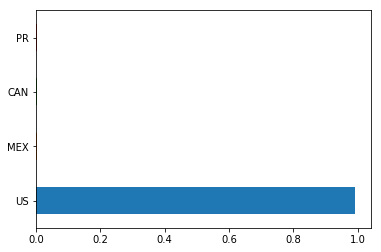

In [20]:
df['merchantCountryCode'].value_counts(normalize=True).plot(kind = 'barh')

In [21]:
df.posEntryMode.value_counts(dropna=False)

05     255615
09     193193
02     160589
90      16251
80      12921
NaN      3345
Name: posEntryMode, dtype: int64

In [22]:
df.posConditionCode.value_counts(dropna=False)

01     514144
08     121507
99       5976
NaN       287
Name: posConditionCode, dtype: int64

In [23]:
# Encoding categorical data
df = pd.get_dummies(df,columns=['creditLimit', 'merchantCategoryCode', 'posEntryMode', 'posConditionCode', 'transactionType'], drop_first=True, dummy_na=True)

In [24]:
df.shape

(641914, 58)

In [25]:
# Check distribution of fraud and non-fraud transactions
df['isFraud'].value_counts() / df.shape[0]

0    0.982393
1    0.017607
Name: isFraud, dtype: float64

In [26]:
# Define a function to create a scatter plot of our data and labels
def plot_data(X, y):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

In [27]:
def get_type_lists(data_frame=df, rejects=['accountNumber','customerId']):
    """Creates lists of numeric and categorical variables.    
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    """
    nums, cats = [], []

    for col in data_frame.columns:
        if col not in rejects:
            type=data_frame[col].dtype
            if type in ('int64','int32','float64') :
                nums.append(col)
            elif str(type) in ('object')  :
                cats.append(col)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

In [28]:
original_nums, cats = get_type_lists()

Numeric = ['availableMoney', 'cardCVV', 'cardLast4Digits', 'cardPresent', 'currentBalance', 'enteredCVV', 'expirationDateKeyInMatch', 'isFraud', 'transactionAmount']

Categorical = ['accountOpenDate', 'acqCountry', 'currentExpDate', 'dateOfLastAddressChange', 'merchantCountryCode', 'merchantName', 'transactionDateTime']


Question 2: Plot

Plot a histogram of the processed amounts of each transaction, the transactionAmount column.
Report any structure you find and any hypotheses you have about that structure.

Text(0.5,0,'Transaction Amount')

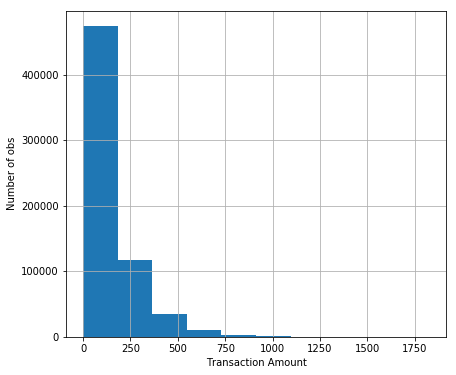

In [29]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = df.transactionAmount.hist(bins=10)
fig.set_ylabel('Number of obs')
fig.set_xlabel('Transaction Amount')

Question 3: Data Wrangling - Duplicate Transactions

You will notice a number of what look like duplicated transactions in the data set. One type of duplicated transaction is a multi-swipe, where a vendor accidentally charges a customer's card multiple times within a short time span. Another example is a reversed transaction, where a purchase is followed by a reversal.

Can you programmatically identify duplicated and reversed transactions?
Did you find anything interesting about either of these transaction types?
What share of transactions (both number of transactions and the dollar amount) do you estimate for the duplicated and reversed transaction types that you identified? In a multi-swipe transaction, please consider the first transaction to be "normal" and exclude it from the number of transaction and dollar amount counts.

In [30]:
#dfduplicates = df[df.duplicated(['accountNumber', 'transactionAmount','merchantName','cardLast4Digits','transactionType'])]
#dfduplicates

In [31]:
#import json
#from datetime import datetime


#convert transaction datetime to datetime; remove letter T at the middle
#df['transactionDateTime'] = df['transactionDateTime'].map(lambda x: datetime.strptime(x.replace('T', ' '), '%Y-%m-%d %H:%M:%S'))


#get all transaction = purchase, all duplicated records and sort values
#df_dup_purchase = df[df['transactionType']=='PURCHASE'][['accountNumber', 'cardLast4Digits', 'merchantName', 'transactionAmount', 'transactionDateTime', 'transactionType']]
#df_dup_purchase = df_dup_purchase[df_dup_purchase.duplicated(subset=['accountNumber', 'cardLast4Digits', 'merchantName', 'transactionAmount', 'transactionType'], keep=False)]
#df_dup_purchase = df_dup_purchase.sort_values(['accountNumber', 'transactionDateTime'], ascending=[True, True])


#create a column time_diff by grouping columns and get the difference (diff) per grouping
#df_dup_purchase['time_diff'] = df_dup_purchase.groupby(['accountNumber', 'cardLast4Digits', 'merchantName', 'transactionAmount', 'transactionType'])['transactionDateTime'].transform(lambda x: x.diff())

#convert time diff from timedelta to minutes
#df_dup_purchase['time_diff'] = df_dup_purchase['time_diff'].transform(lambda x: (x.days)*1440+(x.seconds//3600)*60+(x.seconds//60)%60)

#display duplicate purchases where time diff is within 10mins
#df_dup_purchase[df_dup_purchase.time_diff <= 10]

In [32]:
#dfduplicates.shape

In [33]:
# create a new feature accountAgeYrs to store number of years from accountOpenDate to transactionDateTime 
# and drop 'transactionDateTime','accountOpenDate'
df['transactionDateTime'] = pd.to_datetime(df.transactionDateTime)
df['accountOpenDate'] = pd.to_datetime(df.accountOpenDate)
df['accountAgeYrs']=df['transactionDateTime'].dt.year - df['accountOpenDate'].dt.year

# create a new feature yrsSinceAddressChange to store number of years from yrsSinceAddressChange to transactionDateTime 
# and drop'yrsSinceAddressChange'
df['dateOfLastAddressChange'] = pd.to_datetime(df.dateOfLastAddressChange)
df['yrsSinceAddressChange']=df['transactionDateTime'].dt.year - df['dateOfLastAddressChange'].dt.year

# drop currentExpDate
df.drop(['transactionDateTime','accountOpenDate','dateOfLastAddressChange','currentExpDate'], axis=1, inplace=True)

In [34]:
# create a new feature to indicate if the transaction is domestic or international- 1 means international transaction
df['isInternational']= np.where(df['acqCountry'] == df['merchantCountryCode'], 0,1)
df.isInternational.value_counts(dropna=False)

0    637939
1      3975
Name: isInternational, dtype: int64

In [35]:
# create a new feature incorrectCVV when cardCVV is equal to enteredCVV then 0 else 1 and drop 'enteredCVV','cardCVV'
df['incorrectCVV'] = np.where((df['cardCVV'] == df['enteredCVV']), 0, 1)
# drop cardLast4Digits and customerId as it is the same for each account
df.drop(['accountNumber','enteredCVV','cardCVV', 'cardLast4Digits','customerId', 'acqCountry','merchantCountryCode','merchantName'], axis=1, inplace=True)

In [36]:
# find and remove correlated features to reduce the feature space
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(df, 0.75)
print('correlated features: ', len(set(corr_features)) )

correlated features:  0


In [37]:
# removed correlated  features
df.drop(labels=corr_features, axis=1, inplace=True)

In [38]:
df.shape

(641914, 50)

In [39]:
# remove constant features
constant_features = [
    feat for feat in df.columns if df[feat].std() == 0
]

#df.drop(labels=constant_features, axis=1, inplace=True)


df.shape #, X_test.shape

(641914, 50)

In [40]:
constant_features

['creditLimit_nan', 'merchantCategoryCode_nan']

Question 4: Model

Fraud is a problem for any bank. Fraud can take many forms, whether it is someone stealing a single credit card, to large batches of stolen credit card numbers being used on the web, or even a mass compromise of credit card numbers stolen from a merchant via tools like credit card skimming devices.

Each of the transactions in the dataset has a field called isFraud. Please build a predictive model to determine whether a given transaction will be fraudulent or not. Use as much of the data as you like (or all of it).
Provide an estimate of performance using an appropriate sample, and show your work.
Please explain your methodology (modeling algorithm/method used and why, what features/data you found useful, what questions you have, and what you would do next with more time)

In [41]:
X = df.drop("isFraud", axis=1)
y = df.isFraud

In [42]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641914 entries, 0 to 641913
Data columns (total 49 columns):
availableMoney                               641914 non-null float64
cardPresent                                  641914 non-null int64
currentBalance                               641914 non-null float64
expirationDateKeyInMatch                     641914 non-null int64
transactionAmount                            641914 non-null float64
creditLimit_500.0                            641914 non-null uint8
creditLimit_1000.0                           641914 non-null uint8
creditLimit_2500.0                           641914 non-null uint8
creditLimit_5000.0                           641914 non-null uint8
creditLimit_7500.0                           641914 non-null uint8
creditLimit_10000.0                          641914 non-null uint8
creditLimit_15000.0                          641914 non-null uint8
creditLimit_20000.0                          641914 non-null uint8
creditLimit_

In [43]:
# Import train_test_split
# Split the 'features' and 'income' data into training and testing sets


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 513531 samples.
Testing set has 128383 samples.


In [44]:
# resample data on train set
# Run the prep_data function

# Define the resampling method
method = SMOTE(kind='regular')

# Create the resampled feature set
X_resampled, y_resampled = method.fit_sample(X_train, y_train)
X_resampled.shape, y_resampled.shape

((1009048, 49), (1009048,))

In [45]:
X_train=X_resampled
y_train=y_resampled

In [46]:
X_train.shape, X_test.shape

((1009048, 49), (128383, 49))

In [47]:
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()

# Feature Scaling
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [62]:
X_train

array([[-0.41016073, -0.96778374,  0.06256499, ..., -0.78701501,
        -0.10860921, -0.13255693],
       [-0.01952705, -0.96778374, -0.51379142, ...,  1.50895537,
        -0.10860921, -0.13255693],
       [-0.3404886 ,  1.2190414 , -0.04023204, ..., -0.78701501,
        -0.10860921, -0.13255693],
       ...,
       [-0.20868592, -0.65804682, -0.64665161, ...,  0.19837218,
        -0.10860921, -0.13255693],
       [ 0.25128933, -0.96778374,  0.32249343, ..., -0.75760858,
        -0.10860921, -0.13255693],
       [-0.58369538, -0.96778374,  0.31860488, ..., -0.75392127,
        -0.10860921, -0.13255693]])

In [59]:
sel_ = SelectFromModel(RandomForestClassifier(n_estimators=100))
sel_.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [61]:
sel_.get_support()

array([ True,  True,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True, False, False, False, False, False, False, False,
       False,  True, False, False,  True, False, False,  True,  True,
       False, False, False,  True, False, False, False, False, False,
        True,  True, False, False])

In [60]:
# let's make a list and count the selected features
selected_feat = X_train.columns[(sel_.get_support())]
len(selected_feat)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [50]:
#selected_feat

In [51]:
#X_train=X_train[selected_feat]
#X_test=X_test[selected_feat]

In [52]:
# Fitting Random Forest Classification to the Training set
start = time.time() # Get start time

#classifier = RandomForestClassifier(class_weight='balanced_subsample', n_estimators=150, random_state=5)
#classifier = RandomForestClassifier(n_estimators = 950, criterion = 'entropy', random_state = 0)
classifier = RandomForestClassifier(n_estimators = 150, criterion = 'entropy', random_state = 0)

#classifier = RandomForestClassifier(bootstrap=True,
#                               class_weight={0:1, 1:12}, # 0: non-fraud , 1:fraud 
#                               criterion='entropy',
#                               max_depth=10,
#                               min_samples_leaf=10, 
#                               n_estimators=100, 
#                             n_jobs=-1, random_state=5)

classifier.fit(X_train, y_train)

time_elapsed = time.time() - start
print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

Training complete in 6m 34s


In [53]:
# Predicting the Test set results
start = time.time() # Get start time
y_pred = classifier.predict(X_test)
time_elapsed = time.time() - start
print('Predict complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

Predict complete in 0m 1s


In [54]:
accuracy_score(y_true = y_test, y_pred = y_pred)

0.017876198562114923

In [55]:
#print('Train set')
#print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred_train[:,1])))
#print('Test set')
#print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred_test[:,1])))

In [56]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
cm

array([[     0, 126088],
       [     0,   2295]])

In [57]:
cp=classification_report(y_test, y_pred)
print(cp)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    126088
           1       0.02      1.00      0.04      2295

   micro avg       0.02      0.02      0.02    128383
   macro avg       0.01      0.50      0.02    128383
weighted avg       0.00      0.02      0.00    128383



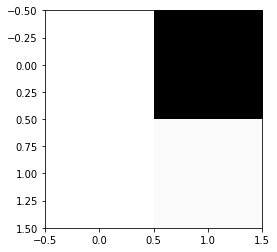

In [58]:
plt.imshow(cm, cmap='binary', interpolation='None')
plt.show()

In [ ]:
# Plot AUROC

In [ ]:
# XGBoost
xgb_model = Pipeline([#("pca", PCA()),
                      ("nmf", NMF()),
                      ("best_features", SelectKBest(chi2)),
                      ("model", XGBClassifier(scale_pos_weight=(1 - Y.mean()), n_jobs=-1))])

In [ ]:
gs = GridSearchCV(xgb_model, {"model__max_depth": [5, 10, 20],
                              "model__min_child_weight": [3, 5, 10],
                              "model__n_estimators": [25, 50, 100]},
                  n_jobs=-1, cv=5, scoring="accuracy")

gs.fit(X_train, y_train)

In [ ]:
start = time.time() # Get start time
print(gs.best_params_)
print(gs.best_score_)
xgb_model.set_params(**gs.best_params_)
xgb_model.fit(X_train, y_train)
time_elapsed = time.time() - start
print('Predict complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

In [ ]:
y_pred = xgb_model.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:
cp=classification_report(y_test, y_pred)
print(cp)

In [ ]:
# lightgbm
lgb_model = Pipeline([#("pca", PCA()),
                      ("nmf", NMF()),
                      ("best_features", SelectKBest(chi2)),
                      ("model", lgb.LGBMClassifier())])

In [ ]:
start = time.time() # Get start time
gs = GridSearchCV(lgb_model, {"model__max_depth": [5, 8, 15],
                              "model__min_child_weight": [1.1, 2, 5],
                              "model__n_estimators": [10, 50, 100]},
                  n_jobs=-1, cv=5, scoring="accuracy")

gs.fit(X_train, y_train)
time_elapsed = time.time() - start
print('Predict complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

In [ ]:
start = time.time() # Get start time
print(gs.best_params_)
print(gs.best_score_)
lgb_model.set_params(**gs.best_params_)
lgb_model.fit(X_train, y_train)
time_elapsed = time.time() - start
print('Predict complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:
cp=classification_report(y_test, y_pred)
print(cp)

In [ ]:
start = time.time() # Get start time
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, y_train,
          epochs=20,
          batch_size=128)
score = model.evaluate(X_test, y_test, batch_size=128)
time_elapsed = time.time() - start
print('Predict complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

In [ ]:
start = time.time() # Get start time
y_pred = model.predict(X_test)
time_elapsed = time.time() - start
print('Predict complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

In [ ]:
y_pred = np.where(y_pred>0.5,1,0)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:
cp=classification_report(y_test, y_pred)
print(cp)